In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from binaryapproximator import *


In [2]:
octet = pd.read_csv('octet.csv')
octet_selected = octet[['sign(Delta E)', 'Delta E', 'IP(A)', 'EA(A)', 'H(A)', 'L(A)', 'rs(A)', 'rp(A)', 'rd(A)', 'IP(B)', 'EA(B)', 'H(B)', 'L(B)', 'rs(B)', 'rp(B)', 'rd(B)', 'EN(A)', 'EN(B)']]
X = octet_selected[['IP(A)', 'EA(A)', 'H(A)', 'L(A)', 'rs(A)', 'rp(A)', 'rd(A)', 'IP(B)', 'EA(B)', 'H(B)', 'L(B)', 'rs(B)', 'rp(B)', 'rd(B)', 'EN(A)', 'EN(B)']].to_numpy()
y = octet_selected[['Delta E']].to_numpy()
# y = octet_selected[['sign(Delta E)']].to_numpy()
y = np.where( y>=0, np.float32(1), np.float32(0))

In [3]:
input = 16
hidden1 = 32
hidden2 = 32
hidden3 = 32
output = 1
n_reps = 1
loss_criterion = nn.BCELoss()
loo_cv = LeaveOneOut()
# dataset = ToTensor(X,y)
# dataloader = DataLoader(dataset=dataset, batch_size=int(len(X)), shuffle=True)

# Scenario 0: Regular NN Training
1. Initialise the Weights
    
For each loop:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

In [15]:
model_finals_0 = np.empty(shape= (n_reps, 82), dtype=object)
epoch_losses_0 = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_0 = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_0_std = np.empty(shape= (82), dtype=object)
train_loss_0 = np.empty(shape= (n_reps, 82), dtype=object)
train_loss_0_std = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in loo_cv.split(X):
        model_base = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, hidden_size3=hidden3, output_size=output)
        tr = TrainNN(X[train_ind], y[train_ind])
        model_final, epoch_loss = tr.nn_training(model=model_base, loss_criterion=loss_criterion)
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_0[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_0[reps, set_ind] = np.mean((y[test_ind]!=np.where(y_pred_test>=0, np.float32(1), np.float32(0))))
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_0[reps, set_ind] = np.mean((y[train_ind]!=np.where(y_pred_train>=0, np.float32(1), np.float32(0))))

        set_ind  += 1

for samp in range(82):
    test_loss_0_std[samp] = test_loss_0[:,samp].std()

for reps in range(n_reps):
    train_loss_0_std[reps] = train_loss_0[reps,:].std()
        

    

0
Early stopping at Epoch 15922 due to small gradients.
Early stopping at Epoch 14827 due to small gradients.
Early stopping at Epoch 15173 due to small gradients.
Early stopping at Epoch 14987 due to small gradients.
Early stopping at Epoch 14719 due to small gradients.
Early stopping at Epoch 15576 due to small gradients.
Early stopping at Epoch 16836 due to small gradients.
Early stopping at Epoch 15061 due to small gradients.
Early stopping at Epoch 14944 due to small gradients.
Early stopping at Epoch 14586 due to small gradients.
Early stopping at Epoch 15073 due to small gradients.
Early stopping at Epoch 15017 due to small gradients.
Early stopping at Epoch 15077 due to small gradients.
Early stopping at Epoch 14860 due to small gradients.
Early stopping at Epoch 14551 due to small gradients.
Early stopping at Epoch 14590 due to small gradients.
Early stopping at Epoch 15259 due to small gradients.
Early stopping at Epoch 14904 due to small gradients.
Early stopping at Epoch 15

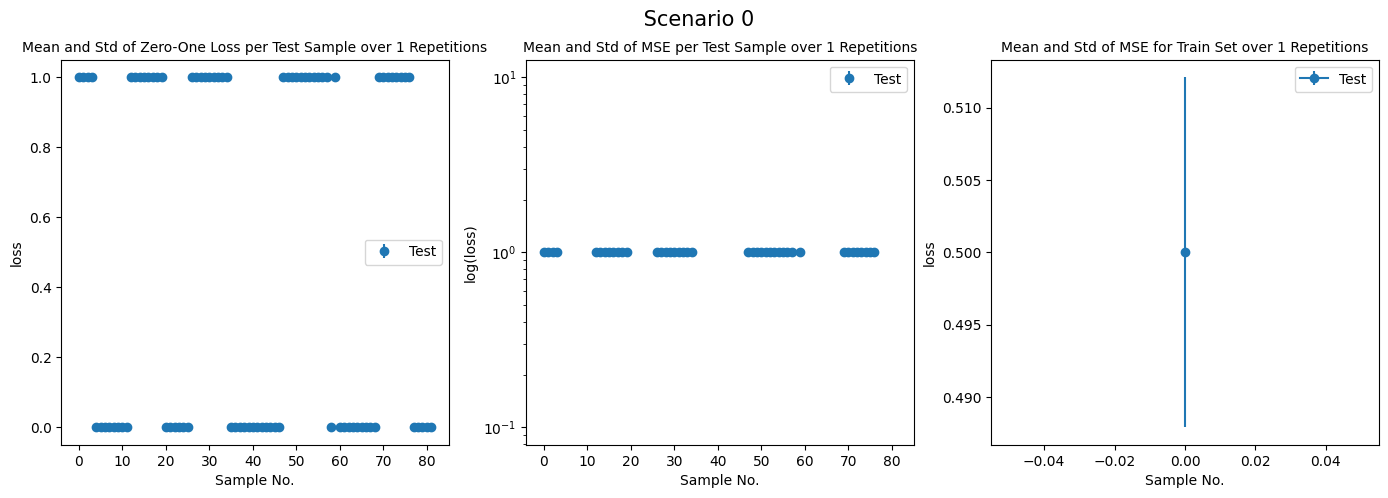

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle(' Scenario 0 ', fontsize=15)
ax[0].errorbar(range(82), test_loss_0.mean(axis=0), yerr=np.array(test_loss_0_std)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Test')
ax[0].set_xlabel("Sample No.")
ax[0].set_ylabel("loss")
ax[0].set_title(f'Mean and Std of Zero-One Loss per Test Sample over {n_reps} Repetitions', fontsize=10)
ax[0].legend()
ax[1].errorbar(range(82), test_loss_0.mean(axis=0), yerr=np.array(test_loss_0_std)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Test')
ax[1].set_xlabel("Sample No.")
ax[1].set_ylabel("log(loss)")
ax[1].set_yscale("log")
ax[1].set_title(f'Mean and Std of MSE per Test Sample over {n_reps} Repetitions', fontsize=10)
ax[1].legend()
ax[2].errorbar(range(n_reps), train_loss_0.mean(axis=1), yerr=np.array(train_loss_0_std)*1.96/(n_reps**0.5), marker='o', label='Test')
ax[2].set_xlabel("Sample No.")
ax[2].set_ylabel("loss")
ax[2].set_title(f'Mean and Std of MSE for Train Set over {n_reps} Repetitions', fontsize=10)
ax[2].legend()

In [ ]:
plt.errorbar(range(n_reps), train_loss_0.mean(axis=1), yerr=np.array(train_loss_0_std)*1.96/(n_reps**0.5), marker='o', linestyle='--', label='Train')
plt.xlabel("Repetition No.")
# plt.yscale("log")
plt.ylabel("loss")
plt.title(f'Average of MSE per Test Sample for {n_reps} Repetitions', fontsize=10)
plt.legend()


# Scenario 1: Rounding the Weights After Each Training
1. Initialise the Weights
    
For each loop:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$ 

In [ ]:
n_reps = 5
model_finals_1 = np.empty(shape= (n_reps, 82), dtype=object)
epoch_losses_1 = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_1 = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_1_std = np.empty(shape= (82), dtype=object)
train_loss_1 = np.empty(shape= (n_reps, 82), dtype=object)
train_loss_1_std = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in loo_cv.split(X):
        model_1 = GeneralRegressionNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, hidden_size3=hidden3, output_size=output)
        for name, param in model_1.named_parameters():
            if name != 'output.weight':
                param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
        tr = TrainNN(X[train_ind], y[train_ind])
        model_final, epoch_loss = tr.nn_training(model=model_1)
        model_final.binarise_model(layer=3)
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_1[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_1[reps, set_ind] = np.mean((y[test_ind]-y_pred_test)**2)
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_1[reps, set_ind] = np.mean((y[train_ind]-y_pred_train)**2)

        set_ind  += 1

for samp in range(82):
    test_loss_1_std[samp] = test_loss_1[:,samp].std()

for reps in range(n_reps):
    train_loss_1_std[reps] = train_loss_1[reps,:].std()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(' Scenario 1 ', fontsize=15)
ax[0].errorbar(range(82), test_loss_1.mean(axis=0), yerr=np.array(test_loss_1_std)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Test')
# ax[0].scatter(range(82), train_loss_0.mean(axis=0), label='Train')
ax[0].set_xlabel("Sample No.")
ax[0].set_ylabel("loss")
ax[0].set_title(f'Mean and Std of MSE for Test Set over {n_reps} Repetitions', fontsize=10)
ax[0].legend()
ax[1].errorbar(range(n_reps), train_loss_1.mean(axis=1), yerr=np.array(train_loss_1_std)*1.96/(n_reps**0.5), marker='o', linestyle='--', label='Train')
ax[1].set_xlabel("Repetition No.")
# ax[1].set_yscale("log")
ax[1].set_ylabel("loss")
ax[1].set_title(f'Mean and Std of MSE for Train Set over {n_reps} Repetitions', fontsize=10)
ax[1].legend()


# Scenario 2: Binarising During Training
1- Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)

For each epoch:

2. Keeping $W_t, \theta_t$ 
3. $W_b = Binarise(W_t)$ 
4. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
5. $loss(y, y_{pred})$ 
6. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
7. $W_{t+1} = W_t + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

8. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

In [ ]:
n_reps = 1
model_finals_2 = np.empty(shape= (n_reps, 82), dtype=object)
epoch_losses_2 = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_2 = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_2_std = np.empty(shape= (82), dtype=object)
train_loss_2 = np.empty(shape= (n_reps, 82), dtype=object)
train_loss_2_std = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in loo_cv.split(X):
        model_2 = GeneralRegressionNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, hidden_size3=hidden3, output_size=output)
        tr = BinaryTrainNN(X[train_ind], y[train_ind])
        model_final, epoch_loss = tr.nn_training(model=model_2)
        model_final.binarise_model(layer=3)
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_2[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_2[reps, set_ind] = np.mean((y[test_ind]-y_pred_test)**2)
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_2[reps, set_ind] = np.mean((y[train_ind]-y_pred_train)**2)

        set_ind  += 1

for samp in range(82):
    test_loss_2_std[samp] = test_loss_2[:,samp].std()

for reps in range(n_reps):
    train_loss_2_std[reps] = train_loss_2[reps,:].std()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(' Scenario 2 ', fontsize=15)
ax[0].errorbar(range(82), test_loss_2.mean(axis=0), yerr=np.array(test_loss_2_std)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Test')
# ax[0].scatter(range(82), train_loss_0.mean(axis=0), label='Train')
ax[0].set_xlabel("Sample No.")
ax[0].set_ylabel("loss")
# ax[0].set_yscale("log")
ax[0].set_title(f'Mean and Std of MSE for Test Set over {n_reps} Repetitions', fontsize=10)
ax[0].legend()
ax[1].errorbar(range(n_reps), train_loss_2.mean(axis=1), yerr=np.array(train_loss_2_std)*1.96/(n_reps**0.5), marker='o', linestyle='--', label='Train')
ax[1].set_xlabel("Repetition No.")
# ax[1].set_yscale("log")
ax[1].set_ylabel("loss")
ax[1].set_title(f'Mean and Std of MSE for Train Set over {n_reps} Repetitions', fontsize=10)
ax[1].legend()